In [1]:
from data_structure import Person, Sentence, Token, Character
import os
import lal
import csv
import scipy
import numpy as np
import pandas as pd

################File paths################
source_dir = "/Users/madalina/Documents/M1TAL/stage_GC/Pro-TEXT_annotated_corpus_v0.3/conll_clean"
head_vectors_file = "head_vectors.txt"
syntactic_measures_csv = "final_lal_output.csv"
fluxes_measures_csv = "pause_fluxes.csv"

In [2]:
def read_conll(source_dir):
    persons = []
    for file in os.listdir(source_dir):
        sentences = []
        if file.startswith("."):
            continue
        file_id = file.split("_")[0]
        source_file_path = os.path.join(source_dir, file)
        data_file = open(source_file_path, "r")
        # print("Processing file: ", source_file_path)
        sentence_string = ""
        data = []
        for line in data_file:
            if line[0] == "\n":
                data.append(sentence_string)
                sentence_string = ""
            else:
                sentence_string = sentence_string + line
        for sentence_string in data:
            sentence_string = sentence_string.strip()
            if sentence_string != "":
                sentence = Sentence.from_string(sentence_string)
                sentences.append(sentence)
        person = Person(file_id, sentences)
        persons.append(person)
        data_file.close()
    return persons

In [9]:
# turn csv into dataframe
df = pd.read_csv("pause_fluxes.csv")
print(df.head())

    Person  Pause_Before  Size  Left_Span  Right_Span  Weight  RL_Ratio  \
0  P18C6E2          2589     1          1           1       1  1.000000   
1  P18C6E2          2074     1          1           1       1  1.000000   
2  P18C6E2          3557     1          1           1       1  1.000000   
3  P18C6E2           281     2          2           1       1  0.500000   
4  P18C6E2          1997     3          3           1       1  0.333333   

   WS =_Ratio  
0    1.000000  
1    1.000000  
2    1.000000  
3    0.500000  
4    0.333333  


In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fit the mixed-effects model
model = smf.mixedlm("Pause_Before ~ Size", df, groups=df["Person"])
result = model.fit()
print(result.summary())

            Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Pause_Before 
No. Observations:  118513   Method:              REML         
No. Groups:        45       Scale:               21888804.4026
Min. group size:   104      Log-Likelihood:      -1169807.6671
Max. group size:   14463    Converged:           Yes          
Mean group size:   2633.6                                     
--------------------------------------------------------------
             Coef.    Std.Err.    z    P>|z|  [0.025   0.975] 
--------------------------------------------------------------
Intercept    4654.007  358.647  12.977 0.000 3951.073 5356.942
Size         -228.013    8.484 -26.877 0.000 -244.641 -211.386
Group Var 5729316.888  267.224                                



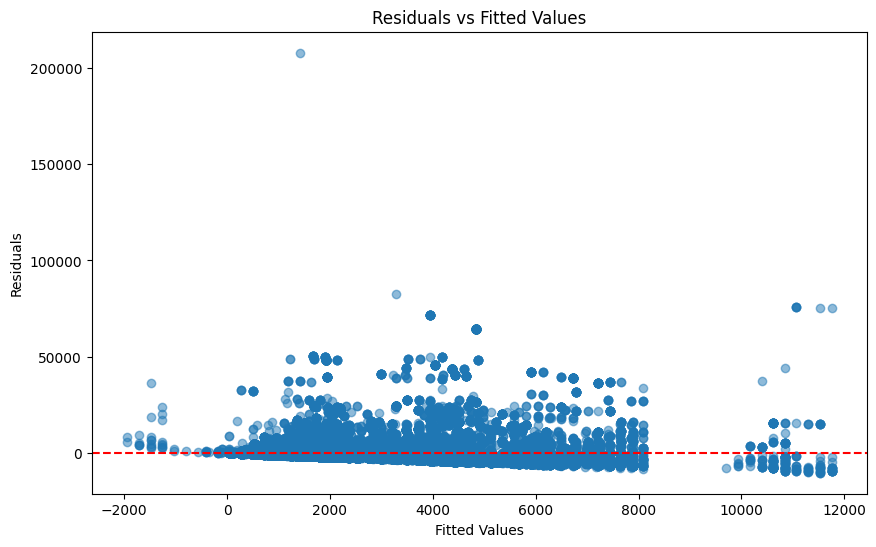

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract residuals and fitted values
fitted_values = result.fittedvalues
residuals = result.resid

# Plot residuals vs fitted values
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

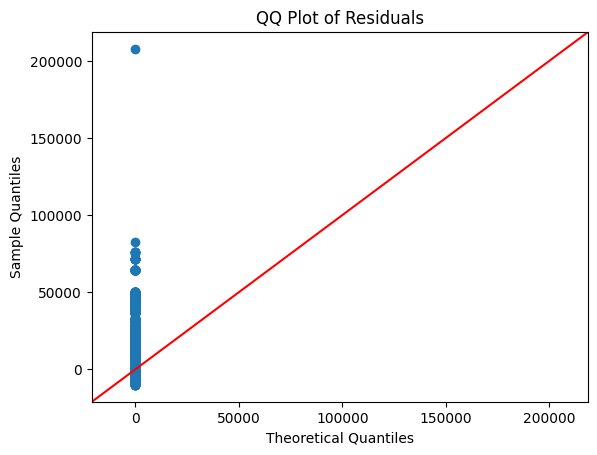

In [12]:
import statsmodels.api as sm

# QQ plot of residuals
sm.qqplot(residuals, line='45')
plt.title('QQ Plot of Residuals')
plt.show()

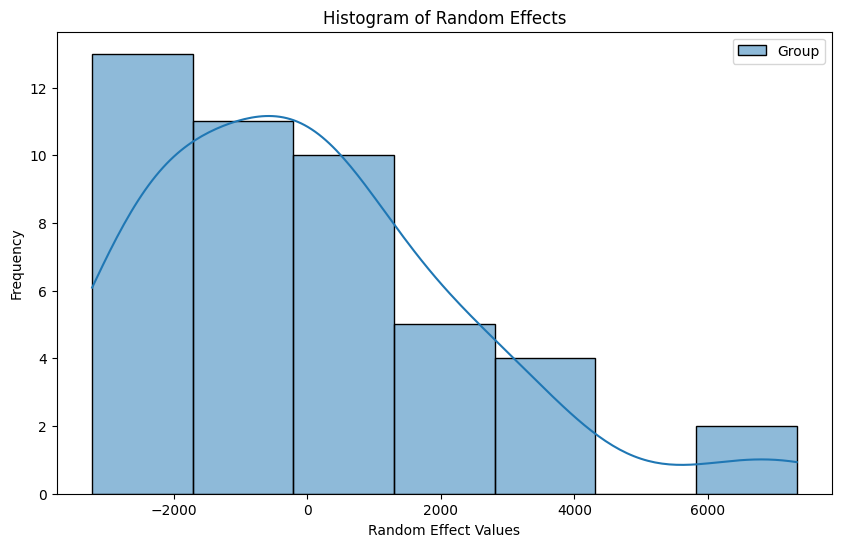

In [13]:
# Extract random effects
random_effects = result.random_effects

# Combine random effects into a single DataFrame
re_df = pd.DataFrame(random_effects).T

# Plot histogram of random effects
plt.figure(figsize=(10, 6))
sns.histplot(re_df, kde=True)
plt.title('Histogram of Random Effects')
plt.xlabel('Random Effect Values')
plt.ylabel('Frequency')
plt.show()

In [14]:
# Fit a simpler model without random effects
model_simple = smf.ols("Pause_Before ~ Size", data=df).fit()

# Print the summary of the simpler model
print(model_simple.summary())

# Compare the two models using AIC and BIC
print("AIC (Mixed-Effects Model):", result.aic)
print("BIC (Mixed-Effects Model):", result.bic)
print("AIC (Simple Model):", model_simple.aic)
print("BIC (Simple Model):", model_simple.bic)

                            OLS Regression Results                            
Dep. Variable:           Pause_Before   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     676.5
Date:                Mon, 29 Jul 2024   Prob (F-statistic):          1.02e-148
Time:                        11:37:53   Log-Likelihood:            -1.1754e+06
No. Observations:              118513   AIC:                         2.351e+06
Df Residuals:                  118511   BIC:                         2.351e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2928.1244     30.046     97.453      0.0

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_Pause_Before
No. Observations: 118513  Method:             REML            
No. Groups:       45      Scale:              1.1019          
Min. group size:  104     Log-Likelihood:     -174064.6335    
Max. group size:  14463   Converged:          Yes             
Mean group size:  2633.6                                      
---------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept       7.648     0.109   70.166  0.000   7.434   7.861
Size           -0.071     0.002  -37.471  0.000  -0.075  -0.068
Group Var       0.532     0.109                                



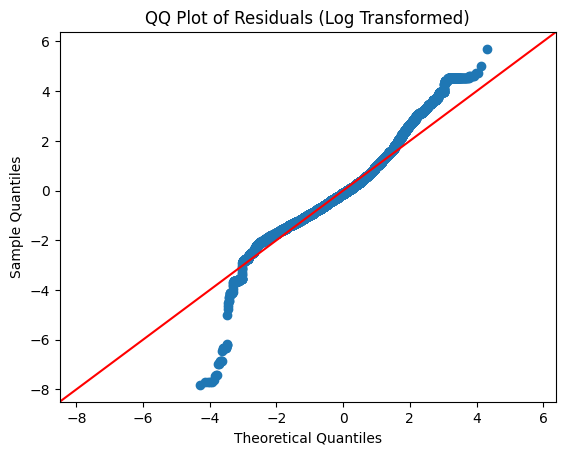

In [15]:
import numpy as np

# Apply log transformation to the dependent variable
df['log_Pause_Before'] = np.log1p(df['Pause_Before'])  # log1p is used to handle zero values

# Fit the mixed-effects model with the transformed dependent variable
model_transformed = smf.mixedlm("log_Pause_Before ~ Size", df, groups=df["Person"])
result_transformed = model_transformed.fit()

# Print the summary of the transformed model
print(result_transformed.summary())

# Plot QQ plot of residuals for the transformed model
residuals_transformed = result_transformed.resid
sm.qqplot(residuals_transformed, line='45')
plt.title('QQ Plot of Residuals (Log Transformed)')
plt.show()


In [16]:
# Identify outliers in residuals
std_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
outliers = np.abs(std_residuals) > 3  # Typically, residuals beyond 3 standard deviations are considered outliers

# Print the outliers
print("Outliers in residuals:")
print(df[outliers])


Outliers in residuals:
          Person  Pause_Before  Size  Left_Span  Right_Span  Weight  RL_Ratio  \
8        P18C6E2         21731     1          1           1       1       1.0   
29       P18C6E2         50060     1          1           1       1       1.0   
44       P18C6E2         50060     1          1           1       1       1.0   
59       P18C6E2         50060     1          1           1       1       1.0   
86       P18C6E2         50060     1          1           1       1       1.0   
...          ...           ...   ...        ...         ...     ...       ...   
118265  P11CE2E2         36489     2          1           2       1       2.0   
118273  P11CE2E2         48283     2          1           2       1       2.0   
118278  P11CE2E2         36489     2          1           2       1       2.0   
118291  P11CE2E2         36489     2          1           2       1       2.0   
118304  P11CE2E2         36489     1          1           1       1       1.0   

    

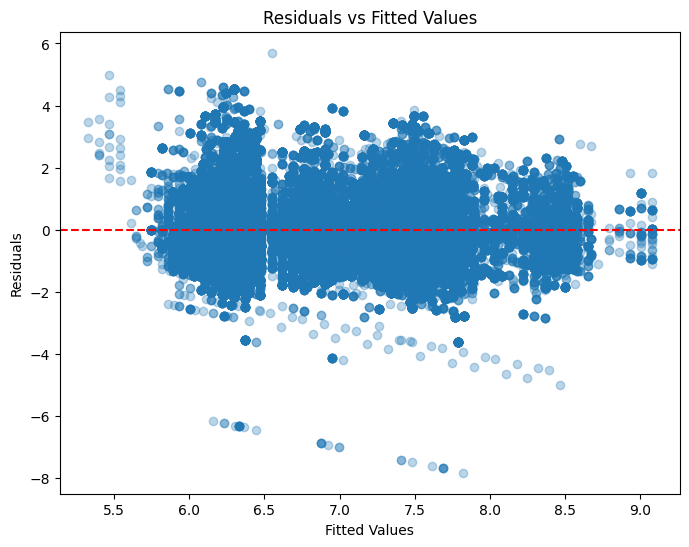

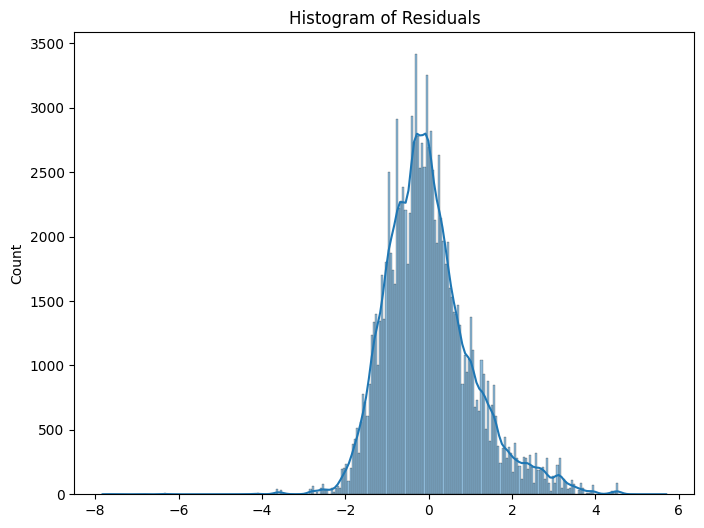

Durbin-Watson statistic: 2.011214059590049


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Residuals vs Fitted plot
fitted_values = result_transformed.fittedvalues
residuals_transformed = result_transformed.resid

plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, residuals_transformed, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals_transformed, kde=True)
plt.title('Histogram of Residuals')
plt.show()

# Durbin-Watson test for autocorrelation
dw_stat = durbin_watson(residuals_transformed)
print(f'Durbin-Watson statistic: {dw_stat}')

# Cook's distance calculation is not available for MixedLMResults
# Alternative diagnostics can be used if needed


In [24]:
# Fit a simpler model without random effects
model_simple = smf.ols("log_Pause_Before ~ Size", data=df).fit()

# Print the summary of the simpler model
print(model_simple.summary())

# Compare the two models using AIC and BIC
print("AIC (Mixed-Effects Model):", result_transformed.aic)
print("BIC (Mixed-Effects Model):", result_transformed.bic)
print("AIC (Simple Model):", model_simple.aic)
print("BIC (Simple Model):", model_simple.bic)

                            OLS Regression Results                            
Dep. Variable:       log_Pause_Before   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1345.
Date:                Mon, 29 Jul 2024   Prob (F-statistic):          1.01e-292
Time:                        14:14:31   Log-Likelihood:            -1.9132e+05
No. Observations:              118513   AIC:                         3.827e+05
Df Residuals:                  118511   BIC:                         3.827e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0703      0.007    950.435      0.0